In [134]:
import os
import pickle
import numpy as np
import torch
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from scipy.integrate import simps
from torch_geometric.data import Data

# Set your dataset path
dataset_path = "/Users/kostasbekis/Emotion_detection/Deap_dataset/deap/data_preprocessed_python"

# Get all .dat files
all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".dat")]

# Load dataset
all_data, all_labels = [], []
for file in all_files:
    with open(file, 'rb') as f:
        file_data = pickle.load(f, encoding='latin1')
        all_data.append(file_data['data'])  # EEG data shape (40, 8064)
        all_labels.append(file_data['labels'])  # Labels shape (4,)

# Convert lists to NumPy arrays
labels = np.array(all_labels).reshape(-1, 4)  # Shape (1280, 4)
data = np.array(all_data).reshape(-1, 40, 8064)  # Shape (1280, 40, 8064)

# Use only the first 32 EEG channels
eeg_data = data[:, :32, :]

print("EEG Data Shape:", eeg_data.shape)  # (1280, 32, 8064)
print("Labels Shape:", labels.shape)  # (1280, 4)


EEG Data Shape: (1280, 32, 8064)
Labels Shape: (1280, 4)


In [135]:
# Function to calculate statistical features
def calculate_statistical_features(data):
    return np.column_stack([
        np.mean(data, axis=1),
        np.std(data, axis=1),
        kurtosis(data, axis=1),
        skew(data, axis=1)
    ])

# Apply feature extraction to each EEG channel
eeg_stat_features = np.hstack([
    calculate_statistical_features(eeg_data[:, i, :]) for i in range(eeg_data.shape[1])
])

print("EEG Statistical Features Shape:", eeg_stat_features.shape)  # (1280, 128)


EEG Statistical Features Shape: (1280, 128)


In [136]:
# EEG Frequency Bands
FREQ_BANDS = {"delta": (0.5, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 64)}

def bandpower(data, sf, band):
    low, high = band
    freqs, psd = welch(data, sf, nperseg=int(2 * sf / low))
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return simps(psd[idx_band], dx=freqs[1] - freqs[0])

# Compute power for each band
eeg_band_features = np.hstack([
    np.array([[bandpower(eeg_data[i, j], 128, FREQ_BANDS[band]) for band in FREQ_BANDS] 
              for j in range(eeg_data.shape[1])]).flatten()
    for i in range(eeg_data.shape[0])
])

# Reshape to (1280, 160)
eeg_band_features = eeg_band_features.reshape(1280, -1)

print("EEG Band Power Features Shape:", eeg_band_features.shape)  # (1280, 160)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_38858/1947442904.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simps(psd[idx_band], dx=freqs[1] - freqs[0])


EEG Band Power Features Shape: (1280, 160)


In [137]:
# Convert to Tensors
features_tensor = torch.tensor(eeg_band_features, dtype=torch.float)
labels_tensor = torch.tensor(labels, dtype=torch.float)

# Normalize labels between 0 and 1
labels_tensor = (labels_tensor - labels_tensor.min()) / (labels_tensor.max() - labels_tensor.min())

print("Final Features Tensor Shape:", features_tensor.shape)  # (1280, 160)
print("Final Labels Tensor Shape:", labels_tensor.shape)  # (1280, 4)


Final Features Tensor Shape: torch.Size([1280, 160])
Final Labels Tensor Shape: torch.Size([1280, 4])


In [138]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class EEG_GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(EEG_GNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x


In [139]:
from torch_geometric.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Split indices
train_idx, test_idx = train_test_split(np.arange(len(features_tensor)), test_size=0.2, random_state=42)

# Masking for train/test
train_mask = torch.zeros(len(features_tensor), dtype=torch.bool)
test_mask = torch.zeros(len(features_tensor), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# Update graph data with masks
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask


Epoch 1, Train Loss: 418100.1562, Test Loss: 144623.5938
Epoch 2, Train Loss: 305611.1562, Test Loss: 89893.0156
Epoch 3, Train Loss: 228996.9062, Test Loss: 55488.7539
Epoch 4, Train Loss: 158911.8281, Test Loss: 38098.8477
Epoch 5, Train Loss: 131202.4219, Test Loss: 33126.7305
Epoch 6, Train Loss: 116827.2500, Test Loss: 35978.0156
Epoch 7, Train Loss: 103684.4531, Test Loss: 41890.4023
Epoch 8, Train Loss: 90063.4062, Test Loss: 47769.2812
Epoch 9, Train Loss: 82031.9219, Test Loss: 51035.2422
Epoch 10, Train Loss: 100394.9141, Test Loss: 50131.5391
Epoch 11, Train Loss: 69749.2734, Test Loss: 47963.3242
Epoch 12, Train Loss: 74852.5234, Test Loss: 44064.9570
Epoch 13, Train Loss: 79805.4141, Test Loss: 38945.1719
Epoch 14, Train Loss: 71208.1094, Test Loss: 33286.5625
Epoch 15, Train Loss: 56027.4023, Test Loss: 27947.6641
Epoch 16, Train Loss: 52513.4023, Test Loss: 23068.7754
Epoch 17, Train Loss: 49739.5703, Test Loss: 18644.1328
Epoch 18, Train Loss: 39864.9336, Test Loss: 147

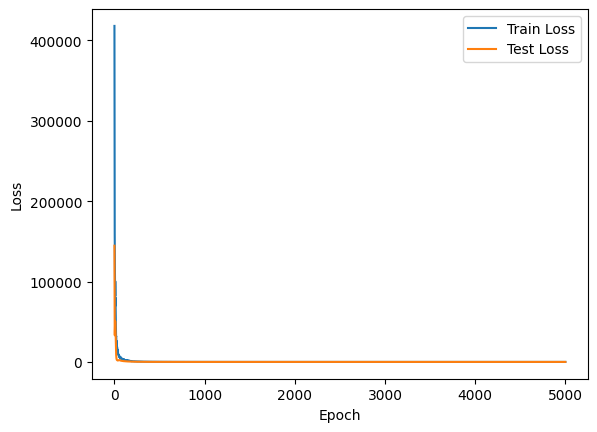

In [140]:
# Training
model = EEG_GNN(in_dim=160, hidden_dim=64, out_dim=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Lists to store loss values
train_losses = []
test_losses = []

for epoch in range(5000):
    model.train()
    optimizer.zero_grad()
    
    # Training loss
    output = model(graph_data.x, graph_data.edge_index)[graph_data.train_mask]
    loss = criterion(output, graph_data.y[graph_data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # Store train loss
    train_losses.append(loss.item())

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_output = model(graph_data.x, graph_data.edge_index)[graph_data.test_mask]
        test_loss = criterion(test_output, graph_data.y[graph_data.test_mask])
        test_losses.append(test_loss.item())

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# ✅ Now you can plot the loss curve
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [141]:
model.eval()
with torch.no_grad():
    test_output = model(graph_data.x, graph_data.edge_index)[graph_data.test_mask]
    test_loss = criterion(test_output, graph_data.y[graph_data.test_mask])

print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.4135


In [142]:
import numpy as np

label_names = ["valence", "arousal", "dominance", "liking"]

# Convert each sample to a single class (0=valence, 1=arousal, 2=dominance, 3=liking)
labels_single_class = np.argmax(labels, axis=1)

print("Converted Labels Shape:", labels_single_class.shape)  # Should be (1280,)
print("Class Distribution:", np.bincount(labels_single_class))  # Check class balance


Converted Labels Shape: (1280,)
Class Distribution: [304 270 329 377]


In [143]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class EEG_GNN_MultiClass(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=4):  # 4 classes: valence, arousal, dominance, liking
        super(EEG_GNN_MultiClass, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)  # Output 4 class logits

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)  # Apply softmax for multi-class classification


In [144]:
criterion = nn.CrossEntropyLoss()  # Standard for multi-class classification


Epoch 1, Train Loss: 3.1487, Test Loss: 3.1321
Epoch 2, Train Loss: 3.1392, Test Loss: 3.1327
Epoch 3, Train Loss: 3.1474, Test Loss: 3.1337
Epoch 4, Train Loss: 3.1404, Test Loss: 3.1342
Epoch 5, Train Loss: 3.1073, Test Loss: 3.1345
Epoch 6, Train Loss: 3.1164, Test Loss: 3.1344
Epoch 7, Train Loss: 3.1262, Test Loss: 3.1339
Epoch 8, Train Loss: 3.0942, Test Loss: 3.1334
Epoch 9, Train Loss: 3.0974, Test Loss: 3.1336
Epoch 10, Train Loss: 3.1371, Test Loss: 3.1340
Epoch 11, Train Loss: 3.1343, Test Loss: 3.1349
Epoch 12, Train Loss: 3.1159, Test Loss: 3.1360
Epoch 13, Train Loss: 3.0957, Test Loss: 3.1374
Epoch 14, Train Loss: 3.1177, Test Loss: 3.1381
Epoch 15, Train Loss: 3.1246, Test Loss: 3.1380
Epoch 16, Train Loss: 3.1109, Test Loss: 3.1374
Epoch 17, Train Loss: 3.1073, Test Loss: 3.1368
Epoch 18, Train Loss: 3.1448, Test Loss: 3.1371
Epoch 19, Train Loss: 3.1149, Test Loss: 3.1369
Epoch 20, Train Loss: 3.1385, Test Loss: 3.1370
Epoch 21, Train Loss: 3.1464, Test Loss: 3.1371
E

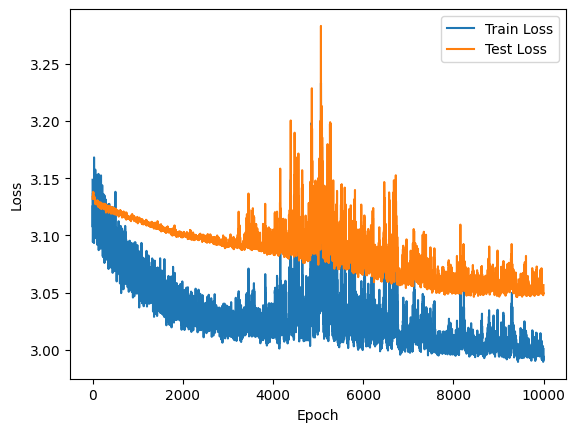

In [145]:
train_losses = []
test_losses = []

for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    
    # Model prediction
    output = model(graph_data.x, graph_data.edge_index)[graph_data.train_mask]
    
    # Compute loss
    loss = criterion(output, graph_data.y[graph_data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_output = model(graph_data.x, graph_data.edge_index)[graph_data.test_mask]
        test_loss = criterion(test_output, graph_data.y[graph_data.test_mask])
        test_losses.append(test_loss.item())

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Plot Loss Curve
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [146]:
def multiclass_accuracy(preds, labels):
    preds = preds.argmax(dim=1)  # Convert softmax output to class index
    labels = labels.argmax(dim=1) if labels.dim() > 1 else labels  # Convert one-hot labels to class indices if necessary
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total


# Evaluate Accuracy
model.eval()
with torch.no_grad():
    test_output = model(graph_data.x, graph_data.edge_index)[graph_data.test_mask]
    test_labels = graph_data.y[graph_data.test_mask]

    acc = multiclass_accuracy(test_output, test_labels)
    print(f"Multi-Class Accuracy: {acc * 100:.2f}%")


Multi-Class Accuracy: 30.86%
